In [ ]:
import pandas as pd
import duckdb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

db = duckdb.connect('imdb.duckdb')

## Feature Engineering

We have the following tables to use:
- movies
- directors
- writers
- talents


In [24]:
db.execute("""     

            SELECT 
                tconst, b.talentid, primaryName, ratings_avg, ratings_count, avg_revenue, num_titles
            FROM title_principals_raw a 
            LEFT JOIN talents b 
            ON a.nconst = b.talentid

    LIMIT 10
""").fetchdf()

,tconst,talentid,primaryName,ratings_avg,ratings_count,avg_revenue,num_titles
0,tt0040316,nm0658575,Fulvio Palmieri,NaN,NaN,NaN,NaN
1,tt0040316,nm0220322,Alexandre Derevitsky,NaN,NaN,NaN,NaN
2,tt0040316,nm1108943,Sacha Derewitsky,NaN,NaN,NaN,NaN
3,tt0040316,nm0691936,Piero Portalupi,NaN,NaN,NaN,NaN
4,tt0040316,nm0146041,Rosalino Caterbetti,NaN,NaN,NaN,NaN
5,tt0040316,nm0505533,Jorge Levillotti,NaN,NaN,NaN,NaN
6,tt0040316,nm1110708,Rosalino,NaN,NaN,NaN,NaN
7,tt0040316,nm0529805,Abel López Chas,NaN,NaN,NaN,NaN
8,tt0040317,nm0001078,Bing Crosby,6.747305,1440.844311,1.050375e+07,167.0
9,tt0040317,nm0000021,Joan Fontaine,6.904124,3222.350515,5.189058e+06,97.0


In [22]:
db.execute('describe talents').fetchdf()

,column_name,column_type,null,key,default,extra
0,talentid,VARCHAR,YES,None,None,None
1,primaryName,VARCHAR,YES,None,None,None
2,ratings_avg,DOUBLE,YES,None,None,None
3,ratings_count,DOUBLE,YES,None,None,None
4,avg_revenue,DOUBLE,YES,None,None,None
5,num_titles,BIGINT,YES,None,None,None


In [19]:
db.execute("""     
    CREATE OR REPLACE TABLE movies3 AS
        WITH ranked_directors AS (
            SELECT 
                a.tconst, 
                b.directorid, 
                b.primaryName, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.tconst ORDER BY b.avg_revenue DESC) AS rownum
            FROM title_directors a 
            LEFT JOIN directors b 
            ON a.directorid = b.directorid
        )
        SELECT 
            c.*,
            ratings_avg as director_ratings_avg, 
            ratings_count as director_ratings_count, 
            avg_revenue as director_avg_revenue, 
            num_titles as director_num_titles
        FROM movies c
        LEFT JOIN
           ranked_directors d
        ON c.tconst = d.tconst
        WHERE rownum = 1;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [25]:
db.execute("""     
    CREATE OR REPLACE TABLE movies4 AS
        WITH ranked_writers AS (
            SELECT 
                a.tconst, 
                b.writerid, 
                b.primaryName, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.tconst ORDER BY b.avg_revenue DESC) AS rownum
            FROM title_writers a 
            LEFT JOIN writers b 
            ON a.writerid = b.writerid
        )
        SELECT 
            c.*,
            ratings_avg as writer_ratings_avg, 
            ratings_count as writer_ratings_count, 
            avg_revenue as writer_avg_revenue, 
            num_titles as writer_num_titles
        FROM movies3 c
        LEFT JOIN
           ranked_writers d
        ON c.tconst = d.tconst
        WHERE rownum = 1;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [26]:
db.execute("""     
    CREATE OR REPLACE TABLE movies5 AS
        WITH ranked_talents AS (
            SELECT 
                a.tconst, 
                b.talentid, 
                b.primaryName, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.tconst ORDER BY b.avg_revenue DESC) AS rownum
            FROM title_principals_raw a 
            LEFT JOIN talents b 
            ON a.nconst = b.talentid
        )
        SELECT 
            c.*,
            ratings_avg as actor1_ratings_avg, 
            ratings_count as actor1_ratings_count, 
            avg_revenue as actor1_avg_revenue, 
            num_titles as actor1_num_titles
        FROM movies4 c
        LEFT JOIN
           ranked_talents d
        ON c.tconst = d.tconst
        WHERE rownum = 1;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [27]:
db.execute("""     
    CREATE OR REPLACE TABLE movies6 AS
        WITH ranked_talents AS (
            SELECT 
                a.tconst, 
                b.talentid, 
                b.primaryName, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.tconst ORDER BY b.avg_revenue DESC) AS rownum
            FROM title_principals_raw a 
            LEFT JOIN talents b 
            ON a.nconst = b.talentid
        )
        SELECT 
            c.*,
            ratings_avg as actor2_ratings_avg, 
            ratings_count as actor2_ratings_count, 
            avg_revenue as actor2_avg_revenue, 
            num_titles as actor2_num_titles
        FROM movies5 c
        LEFT JOIN
           ranked_talents d
        ON c.tconst = d.tconst
        WHERE rownum = 2;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [29]:
db.execute('describe talents').fetchdf()

,column_name,column_type,null,key,default,extra
0,talentid,VARCHAR,YES,None,None,None
1,primaryName,VARCHAR,YES,None,None,None
2,ratings_avg,DOUBLE,YES,None,None,None
3,ratings_count,DOUBLE,YES,None,None,None
4,avg_revenue,DOUBLE,YES,None,None,None
5,num_titles,BIGINT,YES,None,None,None


In [30]:
db.execute('describe title_principals_raw').fetchdf()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,ordering,BIGINT,YES,None,None,None
2,nconst,VARCHAR,YES,None,None,None
3,category,VARCHAR,YES,None,None,None
4,job,VARCHAR,YES,None,None,None
5,characters,VARCHAR,YES,None,None,None


In [33]:
db.execute("""     
    CREATE OR REPLACE TABLE movies7 AS
        SELECT 
            a.*,
            actors_ratings_avg, 
            actors_ratings_count, 
            actors_avg_revenue
        FROM movies6 a
        LEFT JOIN
            (SELECT b.tconst,
                avg(ratings_avg) as actors_ratings_avg, 
                avg(ratings_count) as actors_ratings_count, 
                avg(avg_revenue) as actors_avg_revenue
            FROM
            title_principals_raw b
            LEFT JOIN
            talents c
            ON b.nconst = c.talentid
            GROUP BY b.tconst
            ) d
        ON a.tconst = d.tconst
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

We are done with the feature engineering. We can now export to dataframe for training.

For now, we choose to extract only the movies where revenue is not null. Since the goal is to predict AAA movies, it is the revenue which is paramount and not ratings. However it is also a valid case study to focus on the ratings

## Working with an extracted dataframe

In [37]:
db.execute(""" 
select count(*) from movies7 where revenue >0
""").fetchdf() #15461

,count_star()
0,15461


In [45]:
data = db.execute(""" 
    select tconst, revenue, 
            isAdult, year, runtime, genres, budget,
            dayofyear, weeknum, original_language, --production_companies, 
            director_ratings_avg, director_ratings_count, director_avg_revenue, director_num_titles,
            writer_ratings_avg, writer_ratings_count, writer_avg_revenue, writer_num_titles,
            actor1_ratings_avg, actor1_ratings_count, actor1_avg_revenue, actor1_num_titles,
            actor2_ratings_avg, actor2_ratings_count, actor2_avg_revenue, actor2_num_titles,
            actors_ratings_avg, actors_ratings_count, actors_avg_revenue
    from movies7 where revenue >0
""").fetchdf()

In [46]:
data_exploded = data.explode('genres')
data_one_hot = pd.get_dummies(data_exploded, columns=['genres', 'original_language'])
data_one_hot = data_one_hot.groupby('tconst').max().reset_index()

In [54]:
X = data_one_hot.drop(columns=['tconst', 'revenue'])
y = data_one_hot['revenue']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

In [64]:
bst = xgb.train(params, dtrain, num_boost_round=100)

In [65]:
from sklearn.metrics import r2_score

In [71]:
y_pred = bst.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"The mean squared error is: {mse}")
print(f"The R squared is: {r2}")

The mean squared error is: 3334205920723352.5
The R squared is: 0.819968581199646


<Figure size 1200x800 with 0 Axes>

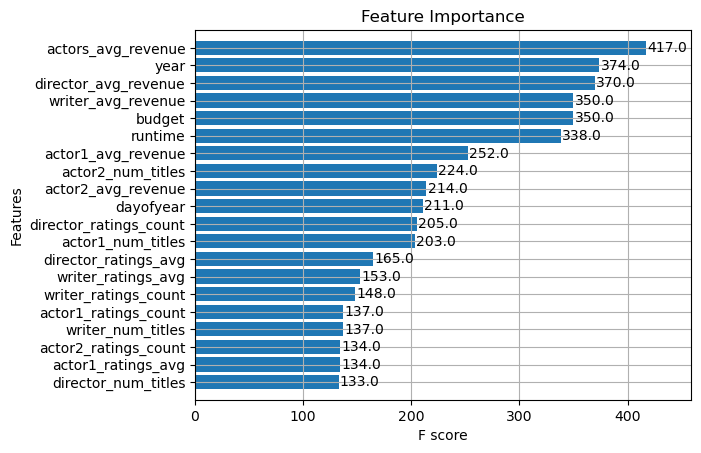

In [73]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(bst, max_num_features=20, height=0.8)
plt.title('Feature Importance')
plt.show()

<Figure size 2000x1500 with 0 Axes>

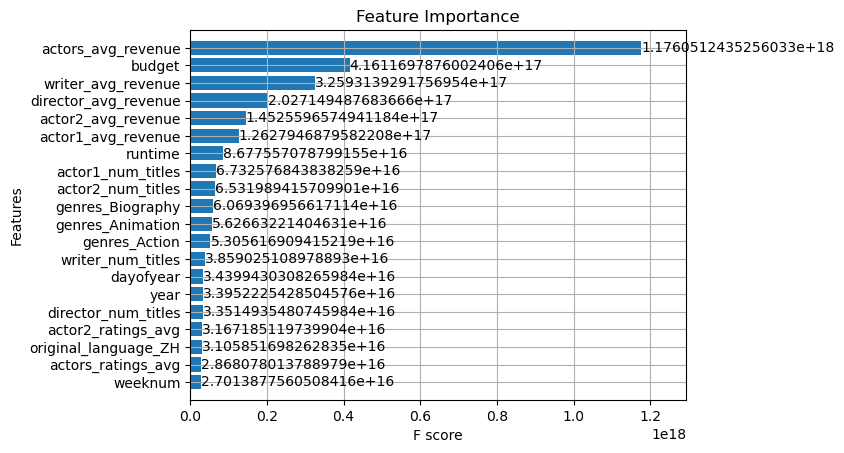

In [72]:
plt.figure(figsize=(20, 15))
xgb.plot_importance(bst, importance_type='gain', max_num_features=20, height=0.8)
plt.title('Feature Importance')
plt.show()